In [180]:
import pandas as pd
import numpy as np
import importlib
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
from pandas.core.interchange.dataframe_protocol import DataFrame
from pygments.lexer import bygroups

import volpy_func_lib as vp
import load_clean_lib
import table_lib

from datetime import datetime
from volpy_func_lib import load_forward_price

In [99]:
# 3 cleaning bud:

# mid price for option > x  (x=~0.1)
# volumen > x
# bid ask spread / mid price < x

In [188]:
importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)

<module 'table_lib' from 'c:\\Users\\axell\\Desktop\\CBS\\master\\volpy\\table_lib.py'>

# Lav Data

## Load, Clean and Prepare data

In [211]:
# Load data
profile = "Axel"
data_folder = "i4s4"   # "i4s4"  ,   "US ZOO"
tickers = ["SPX","OEX","DJX","NDX","MSFT","IBM","GE","AMZN"] #  None
# tickers = ["SPX", "OEX", "AMZN"]
od, FW, ZCY_curves, returns_and_prices = load_clean_lib.load_od_FW_ZCY(profile, data_folder, tickers = tickers)
first_day = od["date"].min()
last_day = od["date"].max()

# first_day = pd.to_datetime("1996-01-04")
# last_day = pd.to_datetime("2003-02-28")

# Clean data
od = load_clean_lib.clean_od(od, first_day = first_day, last_day = last_day)

In [224]:
od['impl_volatility']

1          0.216178
4          0.219093
13         0.252463
14         0.212672
15         0.213853
             ...   
2461492    0.358219
2461495    0.312551
2461496    0.327978
2461497    0.198083
2461498    0.198166
Name: impl_volatility, Length: 1226806, dtype: float64

In [ ]:
aasfasfasf = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\1996-2003 (CarrWu2009)\i4s4\option data.csv)

C:\Users\axell\AppData\Local\Temp\ipykernel_50916\2159500939.py:1: DtypeWarning: Columns (26,32,35) have mixed types. Specify dtype option on import or set low_memory=False.
  aasfasfasf = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\1996-2003 (CarrWu2009)\i4s4\option data.csv")


## Realized vol calculation

In [212]:
real_vol = vp.calc_realized_var(returns_and_prices, first_day, last_day)

### Add FW to options

In [213]:
od = vp.add_FW_to_od(od, FW)

### remove if ITM

In [214]:
od = od.loc[
    ((od["F"] < od["K"]) & (od["cp_flag"] == "C")) | ((od["F"] > od["K"]) & (od["cp_flag"] == "P"))
]

In [105]:
# od = od[od["volume"] > 0]

### Add r to options

In [215]:
od = vp.add_r_to_od_parallel(od, ZCY_curves)

## Add low/high and create summary (Filters dataset for criteria such as min 3 strikes ... min 8 days...)

In [216]:
od, summary_dly_df = vp.od_filter_and_summary_creater(od)

### only keep the lowest ("low") and the second lowest ("high") TTMs

In [217]:
od_rdy = od[(od["low"] == True) | (od["high"] == True)]

## Calculate swap rate

In [218]:
summary_dly_df = vp.fill_swap_rates(summary_dly_df, od_rdy, n_points=200)

Processing Groups: 100%|██████████| 26686/26686 [00:20<00:00, 1323.52it/s]


## Save/Load CSV

In [51]:
# Save
date_str = datetime.now().strftime("%Y-%m_%d_%H-%M")
summary_dly_df.to_csv(f"data/summary_dly_df {date_str}.csv")
od_rdy.to_csv(f"data/od_rdy {date_str}.csv")

# Load
summary_dly_df = pd.read_csv(f"data/summary_dly_df {date_str}.csv")
od_rdy = pd.read_csv(f"data/od_rdy {date_str}.csv")

### her kan du evt. loade fra filen summary_df_dly fra drive (HELLE/Kandidat/results df/summary_dly_df 2025-03_11_11-44.csv). Dette er df over 58 aktiver for 1996-2023

In [52]:
summary_dly_df = pd.read_csv(f"data/summary_dly_df 2025-03_11_11-44.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'data/summary_dly_df 2025-03_11_11-44.csv'

## Keep only active days, and take average for table (just overview)

In [111]:
# # Select only the numeric columns in the DataFrame.
# numeric_cols = summary_dly_df.select_dtypes(include=[np.number]).columns
# 
# # Filter rows where "low SW" is not NaN, group by "Ticker", and calculate the mean for numeric columns.
# filtered_df = summary_dly_df[summary_dly_df["Active"] == True]
# avg_by_ticker = filtered_df.groupby("Ticker")[numeric_cols].mean()
# avg_by_ticker

# Replications of Carr & Wu 2009 Tables

### Merge Realized Vol onto Variance Premium

In [219]:
# Reset index so that 'Date' and 'Ticker' become columns
summary_dly_df_reset = summary_dly_df.reset_index()

# Merge by specifying left_on and right_on keys
merged_df = summary_dly_df_reset.merge(
    real_vol[['date', 'ticker', 'RV', 'open']],
    left_on=['Date', 'Ticker'],
    right_on=['date', 'ticker'],
    how='left'
)

# Optionally, set the index back to ['Date', 'Ticker']
summary_dly_df = merged_df.set_index(['Date', 'Ticker'])
summary_dly_df = summary_dly_df.reset_index()

In [220]:
summary_dly_df = summary_dly_df[summary_dly_df["SW"].notna()]

In [221]:
summary_dly_df["Ticker"].unique()

array(['GE', 'IBM', 'MSFT', 'NDX', 'OEX', 'SPX', 'DJX', 'AMZN'],
      dtype=object)

## Table 1 (Aktive dage)

In [ ]:
importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)

<module 'table_lib' from 'D:\\Professionelt\\Code\\volpy\\table_lib.py'>

In [222]:
importlib.reload(table_lib)
table_lib.CarrWu2009_table_1(summary_dly_df, print_latex = False)

,Ticker,Starting_date,Ending_date,N,NK
7,SPX,04-Jan-1996,28-Feb-2003,1801,31.923098
6,OEX,04-Jan-1996,28-Feb-2003,1801,31.911438
1,DJX,06-Oct-1997,28-Feb-2003,1356,17.929572
5,NDX,04-Jan-1996,28-Feb-2003,1801,36.827596
4,MSFT,04-Jan-1996,28-Feb-2003,1798,10.572303
3,IBM,04-Jan-1996,28-Feb-2003,1798,11.295606
2,GE,08-Jan-1996,28-Feb-2003,1727,6.710770
0,AMZN,20-Nov-1997,28-Feb-2003,1261,13.921491


## Table 2 (SW og RV)

In [223]:
table_lib.CarrWu2009_table_2(summary_dly_df, print_latex = False) # , print_latex = True

,Ticker,Mean_RV,Std_RV,Auto_RV,Skew_RV,Kurt_RV,Mean_SW,Std_SW,Auto_SW,Skew_SW,Kurt_SW
7,SPX,4.096837,3.364648,0.985650,2.105232,5.104466,5.822859,3.181829,0.959574,1.813065,4.149287
6,OEX,4.567990,3.743152,0.985535,2.028253,4.654040,6.074986,3.210560,0.964468,1.617449,2.901213
1,DJX,4.442105,3.641670,0.985064,2.106773,4.238724,6.527394,3.430674,0.868558,1.455293,8.209319
5,NDX,16.455004,15.682873,0.988226,2.506586,8.170743,17.552373,10.816016,0.982977,0.987388,0.371159
4,MSFT,16.697495,13.276314,0.979401,2.343314,6.269572,18.442002,9.826454,0.970196,2.161156,6.921030
3,IBM,15.066254,11.130861,0.972959,1.736097,3.420258,15.935827,7.833802,0.962937,1.877459,4.400490
2,GE,11.118989,8.747200,0.981654,2.126225,5.584654,12.428584,6.936464,0.976303,1.278210,1.743881
0,AMZN,92.645878,58.990356,0.969749,0.913824,0.462935,101.828868,55.343045,0.975642,1.584801,2.940773


## Table 3 (SW - RV og SW/RV)

In [71]:
importlib.reload(table_lib)
table_lib.CarrWu2009_table_3(summary_dly_df, print_latex = False)

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Ticker,Mean_diff,Std_diff,Auto_diff,Skew_diff,Kurt_diff,t_diff,Mean_ln,Std_ln,Auto_ln,Skew_ln,Kurt_ln,t_ln
49,SPX,-1.035110,5.542045,0.889774,5.607854,72.216573,-4.053051,-0.463289,0.678488,0.815757,1.020648,3.219975,NaN
40,OEX,-0.813128,5.267240,0.959823,7.217582,82.671823,-3.116620,-0.455360,0.632301,0.941596,0.690252,4.323986,-14.658936
16,DJX,-1.041301,5.717542,0.961360,8.520317,110.208894,-3.551912,-0.554437,0.631354,0.954619,0.871481,2.742847,NaN
36,NDX,-0.996031,7.514111,0.887363,3.630468,30.745820,-2.874726,-0.323861,0.597536,0.832273,0.870911,3.847973,NaN
46,QQQ,-1.252893,7.161104,0.930220,3.289729,25.623743,-3.457090,-0.374739,0.583283,0.902799,0.651188,1.661609,-12.577378
33,MSFT,-0.838680,9.242625,0.934476,4.183609,36.439175,-1.911272,-0.251741,0.580086,0.920678,0.297939,1.262901,NaN
22,INTC,0.331641,13.721157,0.946361,4.796171,40.106813,0.477078,-0.177957,0.579209,0.921623,0.475174,1.224329,NaN
21,IBM,-1.218246,7.095069,0.884344,2.082845,28.899345,-3.834235,-0.342483,0.638359,0.913337,0.087587,3.139576,NaN
15,DELL,-2.893619,15.946796,0.905076,2.534606,19.271292,-1.732257,-0.366525,0.665916,0.881795,-0.016177,0.470055,NaN
13,CSCO,-0.946381,12.828750,0.927186,2.449013,17.618471,-1.572932,-0.272864,0.638487,0.906727,0.239224,0.876538,NaN


In [7]:
summary_df_temp = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\summary df all\summary_dly_df 2025-03_11_11-44.csv")

In [32]:
importlib.reload(vp)

<module 'volpy_func_lib' from 'c:\\Users\\axell\\Desktop\\CBS\\master\\volpy\\volpy_func_lib.py'>

In [18]:
summary_df_temp[summary_df_temp['ticker']=="SPX"].shape

(6963, 18)

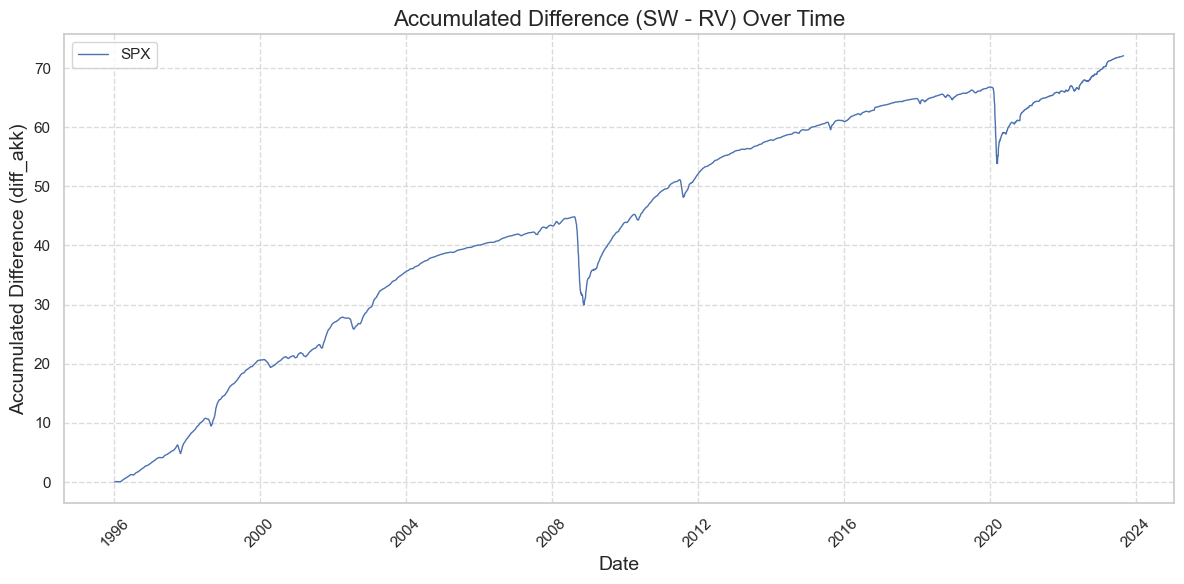

In [38]:
importlib.reload(vp)

vp.plot_diff_akk(summary_df_temp, "SPX", logreturn=False)

## Table 4 (CAPM alpha regression)

## Table 5 (Fama-French alpha regression)

## Table 6 (Constant SW premium test)

## Table 10 (2 subsamples SW/RV ect.)

In [74]:
data_temp = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\1996-2003 (CarrWu2009)\i4s4\option data.csv")

C:\Users\axell\AppData\Local\Temp\ipykernel_13656\2039681507.py:1: DtypeWarning: Columns (26,32,35) have mixed types. Specify dtype option on import or set low_memory=False.
  data_temp = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\1996-2003 (CarrWu2009)\i4s4\option data.csv")


In [64]:
data_temp[data_temp['ticker']=="NDX"].shape

(6965, 5)

In [66]:
data_temp["date"].unique().shape

(6965,)

In [67]:
data_temp['secid'].unique()

array([101310, 102456, 102480, 105169, 106276, 107525, 108105, 109764],
      dtype=int64)

In [75]:
data_temp.shape

(2852230, 38)

In [71]:
data_temp[data_temp["ticker"].isin(["AMZN", "SPX"])].shape


(13583, 5)

In [1]:
import wrds
# Opret forbindelse til WRDS
db = wrds.Connection(wrds_username="axelledue")

c:\Users\axell\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Loading library list...
Done


In [9]:

# Definer start- og slutdato
begdate = '1996-01-04'
enddate = '2003-02-28'

# Liste over tickers
tickers = ["SPX", "OEX", "DJX", "NDX", "MSFT", "IBM", "GE", "AMZN"]

# Hent secid'er for tickers fra securd1
secid_query = f"""
    SELECT secid, ticker, cusip, issuer
    FROM optionm.securd1
    WHERE ticker IN ({', '.join(f"'{t}'" for t in tickers)})
"""
secid_df = db.raw_sql(secid_query)

# Hent alle relevante secid'er
secid_list = tuple(secid_df["secid"].tolist())

# Initialiser en tom liste til at gemme data fra alle år
df_list = []

# Loop gennem alle år og hent data fra hver `fwdprdYYYY`-tabel
for year in range(1996, 2004):
    query = f"""
        SELECT f.secid, s.ticker, s.cusip, s.issuer, 
               f.date, f.expiration, f.amsettlement, f.forwardprice
        FROM optionm.fwdprd{year} f
        LEFT JOIN optionm.securd1 s ON f.secid = s.secid
        WHERE f.secid IN {secid_list}
          AND f.date BETWEEN '{begdate}' AND '{enddate}'
    """
    df_year = db.raw_sql(query, date_cols=["date", "expiration"])
    df_list.append(df_year)  # Tilføj hvert års data til listen

# Kombiner alle år til én dataframe
df = pd.concat(df_list, ignore_index=True)

# Sorter efter ticker og dato
df.sort_values(by=["ticker", "date"], inplace=True)

# Vis de første 10 rækker
print(df.head())

# Gem som CSV
df.to_csv(r"C:\Users\axell\Downloads\test1.csv", index=False)

# Luk WRDS-forbindelsen
db.close()


         secid ticker     cusip           issuer       date expiration  \
8853  101310.0   AMZN  02313510  AMAZON.COM INC. 1997-11-19 1997-12-20   
8854  101310.0   AMZN  02313510  AMAZON.COM INC. 1997-11-19 1998-01-17   
8855  101310.0   AMZN  02313510  AMAZON.COM INC. 1997-11-19 1998-04-18   
8856  101310.0   AMZN  02313510  AMAZON.COM INC. 1997-11-19 1998-07-18   
8857  101310.0   AMZN  02313510  AMAZON.COM INC. 1997-11-20 1997-12-20   

      amsettlement  forwardprice  
8853           0.0     53.563595  
8854           0.0     53.421909  
8855           0.0     53.468429  
8856           0.0     53.868068  
8857           0.0     54.326074  


In [11]:
db = wrds.Connection(wrds_username="axelledue")

# Definer start- og slutdato
begdate = '1996-01-04'
enddate = '2003-02-28'

# Liste over tickers
tickers = ["SPX", "OEX", "DJX", "NDX", "MSFT", "IBM", "GE", "AMZN"]

# Hent secid'er for tickers fra securd1
secid_query = f"""
    SELECT secid, ticker, cusip, issuer
    FROM optionm.securd1
    WHERE ticker IN ({', '.join(f"'{t}'" for t in tickers)})
"""
secid_df = db.raw_sql(secid_query)

# Hent alle relevante secid'er
secid_list = tuple(secid_df["secid"].tolist())

# Initialiser en tom liste til at gemme data fra alle år
df_list = []

# Loop gennem alle år og hent data fra hver `secprdYYYY`-tabel (stock prices & returns)
for year in range(1996, 2004):
    query = f"""
        SELECT p.secid, s.ticker, s.cusip, s.issuer, 
               p.date, p.open, p.close, p.return
        FROM optionm.secprd{year} p
        LEFT JOIN optionm.securd1 s ON p.secid = s.secid
        WHERE p.secid IN {secid_list}
          AND p.date BETWEEN '{begdate}' AND '{enddate}'
    """
    df_year = db.raw_sql(query, date_cols=["date"])
    df_list.append(df_year)  # Tilføj hvert års data til listen

# Kombiner alle år til én dataframe
df = pd.concat(df_list, ignore_index=True)

# Sorter efter ticker og dato
df.sort_values(by=["ticker", "date"], inplace=True)

# Vis de første 10 rækker
print(df.head())

# Gem som CSV-fil i din Downloads-mappe
df.to_csv(r"C:\Users\axell\Downloads\test2.csv", index=False)

# Luk WRDS-forbindelsen
db.close()


Loading library list...
Done
         secid ticker     cusip           issuer       date    open   close  \
1512  101310.0   AMZN  02313510  AMAZON.COM INC. 1997-05-15   29.25    23.5   
1513  101310.0   AMZN  02313510  AMAZON.COM INC. 1997-05-16  23.625   20.75   
1514  101310.0   AMZN  02313510  AMAZON.COM INC. 1997-05-19  21.125    20.5   
1515  101310.0   AMZN  02313510  AMAZON.COM INC. 1997-05-20   20.75  19.625   
1516  101310.0   AMZN  02313510  AMAZON.COM INC. 1997-05-21  19.625  17.125   

        return  
1512      <NA>  
1513 -0.117021  
1514 -0.012048  
1515 -0.042683  
1516 -0.127388  


In [12]:
# Opret forbindelse til WRDS
db = wrds.Connection(wrds_username="din_bruger")

# Definer start- og slutdato
begdate = '1996-01-04'
enddate = '2003-02-28'

# Liste over tickers
tickers = ["SPX", "OEX", "DJX", "NDX", "MSFT", "IBM", "GE", "AMZN"]

# Hent secid'er for tickers fra securd1
secid_query = f"""
    SELECT secid, ticker, cusip, issuer
    FROM optionm.securd1
    WHERE ticker IN ({', '.join(f"'{t}'" for t in tickers)})
"""
secid_df = db.raw_sql(secid_query)

# Hent alle relevante secid'er
secid_list = tuple(secid_df["secid"].tolist())

# Initialiser en tom liste til at gemme data fra alle år
df_list = []

# Loop gennem alle år og hent data fra hver `opprcdYYYY`-tabel (optionsdata)
for year in range(1996, 2004):
    query = f"""
        SELECT o.secid, s.ticker, s.cusip, s.issuer, 
               o.date, o.cp_flag, o.strike_price, o.best_bid, o.best_offer, 
               o.volume, o.open_interest
        FROM optionm.opprcd{year} o
        LEFT JOIN optionm.securd1 s ON o.secid = s.secid
        WHERE o.secid IN {secid_list}
          AND o.date BETWEEN '{begdate}' AND '{enddate}'
    """
    df_year = db.raw_sql(query, date_cols=["date"])
    df_list.append(df_year)  # Tilføj hvert års data til listen

# Kombiner alle år til én dataframe
df = pd.concat(df_list, ignore_index=True)

# Sorter efter ticker og dato
df.sort_values(by=["ticker", "date"], inplace=True)

# Vis de første 10 rækker
print(df.head())

# Gem som CSV-fil i din Downloads-mappe
df.to_csv(r"C:\Users\axell\Downloads\test3.csv", index=False)

# Luk WRDS-forbindelsen
db.close()


WRDS recommends setting up a .pgpass file.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
           secid ticker     cusip           issuer       date cp_flag  \
248346  101310.0   AMZN  02313510  AMAZON.COM INC. 1997-11-19       P   
248347  101310.0   AMZN  02313510  AMAZON.COM INC. 1997-11-19       P   
248348  101310.0   AMZN  02313510  AMAZON.COM INC. 1997-11-19       P   
248349  101310.0   AMZN  02313510  AMAZON.COM INC. 1997-11-19       C   
248350  101310.0   AMZN  02313510  AMAZON.COM INC. 1997-11-19       C   

        strike_price  best_bid  best_offer  volume  open_interest  
248346       60000.0    11.125       11.25     0.0            0.0  
248347       60000.0     9.125       9.375     0.0            0.0  
248348       55000.0     5.875         6.0   100.0          100.0  
248349       40000.0     19.75       19.75     0.0            0.0  
248350       40000.0     17.75      17.875     0.0           30

In [13]:
data_temp2 = pd.read_csv(r"C:\Users\axell\Downloads\test3.csv")

C:\Users\axell\AppData\Local\Temp\ipykernel_1336\2658475250.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_temp2 = pd.read_csv(r"C:\Users\axell\Downloads\test3.csv")


In [14]:
data_temp2.shape

(3527784, 11)

In [15]:
data_temp3 = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\1996-2003 (CarrWu2009)\i4s4\option data.csv")

C:\Users\axell\AppData\Local\Temp\ipykernel_1336\462775295.py:1: DtypeWarning: Columns (26,32,35) have mixed types. Specify dtype option on import or set low_memory=False.
  data_temp3 = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\1996-2003 (CarrWu2009)\i4s4\option data.csv")


In [16]:
data_temp3.shape

(2852230, 38)

In [ ]:
# import wrds
# import pandas as pd

# def fetch_options_data(begdate, enddate, tickers, csv_path):
#     db = wrds.Connection(wrds_username="din_bruger")

#     """Henter optionsdata fra WRDS og gemmer som CSV."""
    
#     if isinstance(tickers, str):
#         tickers = [tickers]

#     # Hent secid'er for tickers
#     secid_df = db.raw_sql(f"""
#         SELECT secid, ticker, cusip, issuer
#         FROM optionm.securd1
#         WHERE ticker IN ({', '.join(f"'{t}'" for t in tickers)})
#     """)

#     secid_list = tuple(secid_df["secid"].tolist())
#     df_list = []

#     for year in range(max(int(begdate[:4]),1996), min(int(enddate[:4]) + 1,2024)):
#         query = f"""
#             SELECT o.secid, s.ticker, s.cusip, s.issuer, 
#                    o.date, o.cp_flag, o.strike_price, 
#                    o.best_bid, o.best_offer, o.volume, o.open_interest
#             FROM optionm.opprcd{year} o
#             LEFT JOIN optionm.securd1 s ON o.secid = s.secid
#             WHERE o.secid IN {secid_list}
#               AND o.date BETWEEN '{begdate}' AND '{enddate}'
#         """
#         df_list.append(db.raw_sql(query, date_cols=["date"]))

#     df = pd.concat(df_list, ignore_index=True)
#     df.sort_values(by=["ticker", "date"], inplace=True)
#     df.to_csv(csv_path, index=False)
#     # Luk WRDS-forbindelsen, når vi er færdige
#     db.close()

#     return df

# def fetch_forward_prices(begdate, enddate, tickers, csv_path):
#     db = wrds.Connection(wrds_username="din_bruger")

#     """Henter forward prices fra WRDS og gemmer som CSV."""

#     if isinstance(tickers, str):
#         tickers = [tickers]

#     secid_df = db.raw_sql(f"""
#         SELECT secid, ticker, cusip, issuer
#         FROM optionm.securd1
#         WHERE ticker IN ({', '.join(f"'{t}'" for t in tickers)})
#     """)

#     secid_list = tuple(secid_df["secid"].tolist())
#     df_list = []

#     for year in range(max(int(begdate[:4]),1996), min(int(enddate[:4]) + 1,2024)):
#         query = f"""
#             SELECT f.secid, s.ticker, s.cusip, s.issuer, 
#                    f.date, f.expiration, f.amsettlement, f.forwardprice
#             FROM optionm.fwdprd{year} f
#             LEFT JOIN optionm.securd1 s ON f.secid = s.secid
#             WHERE f.secid IN {secid_list}
#               AND f.date BETWEEN '{begdate}' AND '{enddate}'
#         """
#         df_list.append(db.raw_sql(query, date_cols=["date", "expiration"]))

#     df = pd.concat(df_list, ignore_index=True)
#     df.sort_values(by=["ticker", "date"], inplace=True)
#     df.to_csv(csv_path, index=False)
#     # Luk WRDS-forbindelsen, når vi er færdige
#     db.close()

#     return df

# def fetch_stock_returns(begdate, enddate, tickers, csv_path):
#     db = wrds.Connection(wrds_username="din_bruger")

#     """Henter stock prices & returns fra WRDS og gemmer som CSV."""

#     if isinstance(tickers, str):
#         tickers = [tickers]

#     secid_df = db.raw_sql(f"""
#         SELECT secid, ticker, cusip, issuer
#         FROM optionm.securd1
#         WHERE ticker IN ({', '.join(f"'{t}'" for t in tickers)})
#     """)

#     secid_list = tuple(secid_df["secid"].tolist())
#     df_list = []

#     for year in range(max(int(begdate[:4]),1996), min(int(enddate[:4]) + 1,2024)):
#         query = f"""
#             SELECT p.secid, s.ticker, s.cusip, s.issuer, 
#                    p.date, p.open, p.close, p.return
#             FROM optionm.secprd{year} p
#             LEFT JOIN optionm.securd1 s ON p.secid = s.secid
#             WHERE p.secid IN {secid_list}
#               AND p.date BETWEEN '{begdate}' AND '{enddate}'
#         """
#         df_list.append(db.raw_sql(query, date_cols=["date"]))

#     df = pd.concat(df_list, ignore_index=True)
#     df.sort_values(by=["ticker", "date"], inplace=True)
#     df.to_csv(csv_path, index=False)

#     # Luk WRDS-forbindelsen, når vi er færdige
#     db.close()

#     return df

# def fetch_wrds_data(begdate, enddate, tickers, data_type, csv_path):

#     function_map = {
#         "O": fetch_options_data,
#         "F": fetch_forward_prices,
#         "R": fetch_stock_returns
#     }

#     if data_type not in function_map:
#         raise ValueError("Ugyldig data_type. Brug 'od', 'F', eller 'R'.")
    


#     return function_map[data_type](begdate, enddate, tickers, csv_path)




In [ ]:
db = wrds.Connection(wrds_username="axelledue")

In [69]:
import wrds
import pandas as pd

def fetch_options_data(begdate, enddate, tickers, csv_path):
    # db = wrds.Connection(wrds_username=username)

    secid_list = None  # Default: Hent hele databasen

    if tickers:
        if isinstance(tickers, str):
            tickers = [tickers]

        secid_df = db.raw_sql(f"""
            SELECT secid, ticker, cusip, issuer
            FROM optionm.securd1
            WHERE ticker IN ({', '.join(f"'{t}'" for t in tickers)})
        """)

        secid_list = secid_df["secid"].tolist()

        # Konverter til SQL-venlig streng
        if len(secid_list) == 1:
            secid_str = f"({secid_list[0]})"  # Ingen komma, hvis kun én værdi
        elif secid_list:
            secid_str = f"({', '.join(map(str, secid_list))})"  # Normal liste
        else:
            secid_str = "(NULL)"  # Ingen secid'er fundet

    df_list = []

    for year in range(max(int(begdate[:4]), 1996), min(int(enddate[:4]) + 1, 2024)):
        query = f"""
            SELECT o.secid, s.ticker, o.optionid, s.cusip, s.issuer, 
                   o.date, o.exdate, o.cp_flag, o.strike_price, 
                   o.best_bid, o.best_offer, o.impl_volatility, o.volume, o.open_interest,
                   o.cfadj, ss_flag
            FROM optionm.opprcd{year} o
            LEFT JOIN optionm.securd1 s ON o.secid = s.secid
            WHERE o.date BETWEEN '{begdate}' AND '{enddate}'
        """

        if secid_list:
            query += f" AND o.secid IN {secid_str}"  # Filtrér kun, hvis tickers blev angivet

        df_list.append(db.raw_sql(query, date_cols=["date"]))

    df = pd.concat(df_list, ignore_index=True)
    df.sort_values(by=["ticker", "date"], inplace=True)
    df.to_csv(csv_path, index=False)
    
    # db.close()
    return df


def fetch_forward_prices(begdate, enddate, tickers, csv_path):
    # db = wrds.Connection(wrds_username=username)

    secid_list = None

    if tickers:
        if isinstance(tickers, str):
            tickers = [tickers]

        secid_df = db.raw_sql(f"""
            SELECT secid, ticker, cusip, issuer
            FROM optionm.securd1
            WHERE ticker IN ({', '.join(f"'{t}'" for t in tickers)})
        """)

        secid_list = secid_df["secid"].tolist()

        # Konverter til SQL-venlig streng
        if len(secid_list) == 1:
            secid_str = f"({secid_list[0]})"  # Ingen komma, hvis kun én værdi
        elif secid_list:
            secid_str = f"({', '.join(map(str, secid_list))})"  # Normal liste
        else:
            secid_str = "(NULL)"  # Ingen secid'er fundet

    df_list = []

    for year in range(max(int(begdate[:4]), 1996), min(int(enddate[:4]) + 1, 2024)):
        query = f"""
            SELECT f.secid, s.ticker, s.cusip, s.issuer, 
                   f.date, f.expiration, f.amsettlement, f.forwardprice
            FROM optionm.fwdprd{year} f
            LEFT JOIN optionm.securd1 s ON f.secid = s.secid
            WHERE f.date BETWEEN '{begdate}' AND '{enddate}'
        """

        if secid_list:
            query += f" AND f.secid IN {secid_str}"

        df_list.append(db.raw_sql(query, date_cols=["date", "expiration"]))

    df = pd.concat(df_list, ignore_index=True)
    df.sort_values(by=["ticker", "date"], inplace=True)
    df.to_csv(csv_path, index=False)
    
    # db.close()
    return df


def fetch_stock_returns(begdate, enddate, tickers, csv_path):
    # db = wrds.Connection(wrds_username=username)

    secid_list = None

    if tickers:
        if isinstance(tickers, str):
            tickers = [tickers]

        secid_df = db.raw_sql(f"""
            SELECT secid, ticker, cusip, issuer
            FROM optionm.securd1
            WHERE ticker IN ({', '.join(f"'{t}'" for t in tickers)})
        """)

        secid_list = secid_df["secid"].tolist()

        # Konverter til SQL-venlig streng
        if len(secid_list) == 1:
            secid_str = f"({secid_list[0]})"  # Ingen komma, hvis kun én værdi
        elif secid_list:
            secid_str = f"({', '.join(map(str, secid_list))})"  # Normal liste
        else:
            secid_str = "(NULL)"  # Ingen secid'er fundet

    df_list = []

    for year in range(max(int(begdate[:4]), 1996), min(int(enddate[:4]) + 1, 2024)):
        query = f"""
            SELECT p.secid, s.ticker, s.cusip, s.issuer, 
                   p.date, p.open, p.close, p.return
            FROM optionm.secprd{year} p
            LEFT JOIN optionm.securd1 s ON p.secid = s.secid
            WHERE p.date BETWEEN '{begdate}' AND '{enddate}'
        """

        if secid_list:
            query += f" AND p.secid IN {secid_str}"

        df_list.append(db.raw_sql(query, date_cols=["date"]))

    df = pd.concat(df_list, ignore_index=True)
    df.sort_values(by=["ticker", "date"], inplace=True)
    df.to_csv(csv_path, index=False)

    # db.close()
    return df


def fetch_wrds_data(begdate, enddate, tickers, data_type, csv_path):

    function_map = {
        "O": fetch_options_data,
        "F": fetch_forward_prices,
        "S": fetch_stock_returns
    }

    if data_type not in function_map:
        raise ValueError("Ugyldig data_type. Brug 'O', 'F', eller 'R'.")

    return function_map[data_type](begdate, enddate, tickers, csv_path)


In [72]:
db = wrds.Connection(wrds_username="axelledue")
# db.close

Loading library list...
Done


In [71]:
db.close

<bound method Connection.close of <wrds.sql.Connection object at 0x000002BBD1EDFF50>>

In [73]:
df_options = fetch_wrds_data(
    begdate="1996-01-04", 
    enddate="2003-02-28", #2024-12-31 2003-02-28
    tickers=["SPX","OEX","DJX","NDX","MSFT","IBM","GE","AMZN"], 
    data_type="O", 
    csv_path=r"C:\Users\axell\Downloads\testmedmads.csv"
)
df_options

,secid,ticker,optionid,cusip,issuer,date,exdate,cp_flag,strike_price,best_bid,best_offer,impl_volatility,volume,open_interest,cfadj,ss_flag
248346,101310.0,AMZN,10042730.0,02313510,AMAZON.COM INC.,1997-11-19,1998-01-17,P,60000.0,11.125,11.25,0.835161,0.0,0.0,1.0,0
248347,101310.0,AMZN,10185899.0,02313510,AMAZON.COM INC.,1997-11-19,1997-12-20,P,60000.0,9.125,9.375,0.834037,0.0,0.0,1.0,0
248348,101310.0,AMZN,10400064.0,02313510,AMAZON.COM INC.,1997-11-19,1997-12-20,P,55000.0,5.875,6.0,0.828668,100.0,100.0,1.0,0
248349,101310.0,AMZN,10403477.0,02313510,AMAZON.COM INC.,1997-11-19,1998-07-18,C,40000.0,19.75,19.75,0.811837,0.0,0.0,1.0,0
248350,101310.0,AMZN,10409566.0,02313510,AMAZON.COM INC.,1997-11-19,1998-04-18,C,40000.0,17.75,17.875,0.833819,0.0,30.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3516835,108105.0,SPX,20847180.0,64881510,CBOE S&P 500 INDEX,2003-02-28,2003-09-20,P,1250000.0,408.3,408.8,0.211222,0.0,50.0,1.0,0
3516836,108105.0,SPX,20847181.0,64881510,CBOE S&P 500 INDEX,2003-02-28,2003-09-20,P,1275000.0,433.0,433.5,0.208088,0.0,20.0,1.0,0
3516837,108105.0,SPX,20847182.0,64881510,CBOE S&P 500 INDEX,2003-02-28,2003-09-20,P,1200000.0,358.9,359.4,0.20695,0.0,82.0,1.0,0
3516838,108105.0,SPX,20570646.0,64881510,CBOE S&P 500 INDEX,2003-02-28,2003-12-20,P,1250000.0,408.9,409.4,0.196829,0.0,633.0,1.0,0


In [173]:
df_options.shape

(3527784, 17)

In [176]:
# Konverter date og exdate til datetime, hvis de ikke allerede er det
df_options["date"] = pd.to_datetime(df_options["date"])
df_options["exdate"] = pd.to_datetime(df_options["exdate"])

# Beregn forskellen mellem exdate og date i dage
df_options["days_diff"] = (df_options["exdate"] - df_options["date"]).dt.days

# Filtrer data: Behold kun rækker hvor forskellen er > 8 dage
df_options_v2 = df_options[df_options["days_diff"] >= 8]  # Første filter
df_options_v2 = df_options_v2[df_options_v2["days_diff"] <= 365].drop(columns=["days_diff"])  # Andet filter


In [179]:
df_options[df_options['days_diff']==8].shape

(35018, 17)

In [178]:
dftemp.shape

(2852230, 38)

In [175]:
dftemp = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\1996-2003 (CarrWu2009)\i4s4\option data.csv")

C:\Users\axell\AppData\Local\Temp\ipykernel_50916\425114702.py:1: DtypeWarning: Columns (26,32,35) have mixed types. Specify dtype option on import or set low_memory=False.
  dftemp = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\1996-2003 (CarrWu2009)\i4s4\option data.csv")


In [ ]:
# Konverter date og exdate til datetime, hvis de ikke allerede er det
dftemp["date"] = pd.to_datetime(dftemp["date"])
dftemp["exdate"] = pd.to_datetime(dftemp["exdate"])

# Beregn forskellen mellem exdate og date i dage
dftemp["days_diff"] = (dftemp["exdate"] - dftemp["date"]).dt.days

In [169]:
dftemp['days_diff'].max()

365

# filterring df_options 

In [ ]:
import pandas as pd

# Konverter date og exdate til datetime, hvis de ikke allerede er det
df_options["date"] = pd.to_datetime(df_options["date"])
df_options["exdate"] = pd.to_datetime(df_options["exdate"])

# Beregn forskellen mellem exdate og date i dage
df_options["days_diff"] = (df_options["exdate"] - df_options["date"]).dt.days

# Filtrer data: Behold kun rækker hvor forskellen er > 8 dage
df_options_v2 = df_options[df_options["days_diff"] > 8].drop(columns=["days_diff"])


           secid ticker    optionid     cusip           issuer       date  \
248346  101310.0   AMZN  10042730.0  02313510  AMAZON.COM INC. 1997-11-19   
248347  101310.0   AMZN  10185899.0  02313510  AMAZON.COM INC. 1997-11-19   
248348  101310.0   AMZN  10400064.0  02313510  AMAZON.COM INC. 1997-11-19   
248349  101310.0   AMZN  10403477.0  02313510  AMAZON.COM INC. 1997-11-19   
248350  101310.0   AMZN  10409566.0  02313510  AMAZON.COM INC. 1997-11-19   

           exdate cp_flag  strike_price  best_bid  best_offer  \
248346 1998-01-17       P       60000.0    11.125       11.25   
248347 1997-12-20       P       60000.0     9.125       9.375   
248348 1997-12-20       P       55000.0     5.875         6.0   
248349 1998-07-18       C       40000.0     19.75       19.75   
248350 1998-04-18       C       40000.0     17.75      17.875   

        impl_volatility  volume  open_interest  cfadj ss_flag  
248346         0.835161     0.0            0.0    1.0       0  
248347         0.8

In [159]:
import pandas as pd

# Sikre at "date" er datetime-format i begge dataframes
df_options_v2['date'] = pd.to_datetime(df_options_v2['date'])
dftemp['date'] = pd.to_datetime(dftemp['date'])

# Merge df_options (den lange) med dftemp (den korte) på "ticker", "date" og "best_bid"
merged_df = df_options_v2.merge(
    dftemp[['ticker', 'date', 'best_bid', 'best_offer', 'exdate', 'strike_price', 'cp_flag']],  # Kun relevante kolonner fra dftemp
    on=['ticker', 'date', 'best_bid', 'best_offer', 'exdate', 'strike_price', 'cp_flag'],
    how='left',
    indicator=True  # Tilføjer en kolonne "_merge" til at identificere matches
)

# Opret kolonnen "found in original" baseret på match
merged_df["found in original"] = merged_df["_merge"] == "both"

# Fjern "_merge"-kolonnen, da den ikke længere er nødvendig
merged_df.drop(columns=["_merge"], inplace=True)

In [125]:
# df_options[(df_options['date'] == pd.Timestamp("1997-12-15")) & (df_options['ticker']=="AMZN")]

In [166]:
merged_df[(merged_df['found in original']==False)] 

,secid,ticker,optionid,cusip,issuer,date,exdate,cp_flag,strike_price,best_bid,best_offer,impl_volatility,volume,open_interest,cfadj,ss_flag,found in original
21977,101310.0,AMZN,10153792.0,02313510,AMAZON.COM INC.,1998-10-09,2000-01-22,C,100500.0,32.125,32.625,0.935941,0.0,0.0,1.0,0,False
21992,101310.0,AMZN,10353796.0,02313510,AMAZON.COM INC.,1998-10-09,2000-01-22,C,120000.0,27.0,26.875,0.910896,5.0,5.0,1.0,0,False
21993,101310.0,AMZN,10381893.0,02313510,AMAZON.COM INC.,1998-10-09,2000-01-22,C,110250.0,29.25,29.75,0.922242,0.0,0.0,1.0,0,False
22017,101310.0,AMZN,10656791.0,02313510,AMAZON.COM INC.,1998-10-09,2000-01-22,P,120000.0,56.875,57.625,0.963683,0.0,0.0,1.0,0,False
22030,101310.0,AMZN,10786615.0,02313510,AMAZON.COM INC.,1998-10-09,2000-01-22,P,100500.0,42.5,43.25,0.96411,0.0,0.0,1.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334321,108105.0,SPX,21386572.0,64881510,CBOE S&P 500 INDEX,2003-02-28,2004-12-18,P,1100000.0,279.1,279.6,0.216737,0.0,0.0,1.0,0,False
3334322,108105.0,SPX,21406681.0,64881510,CBOE S&P 500 INDEX,2003-02-28,2004-12-18,P,1200000.0,363.7,364.2,0.209314,0.0,13.0,1.0,0,False
3334323,108105.0,SPX,21347165.0,64881510,CBOE S&P 500 INDEX,2003-02-28,2004-12-18,P,1250000.0,408.5,409.0,0.207218,0.0,12.0,1.0,0,False
3334324,108105.0,SPX,21381827.0,64881510,CBOE S&P 500 INDEX,2003-02-28,2004-12-18,P,1300000.0,453.8,454.3,0.201995,0.0,97.0,1.0,0,False


In [165]:
merged_df[(merged_df['date'] == pd.Timestamp("2000-12-15")) & (merged_df['ticker']=="AMZN")]   # & (merged_df['found in original']==True)  & (merged_df['ticker']=="AMZN") 

,secid,ticker,optionid,cusip,issuer,date,exdate,cp_flag,strike_price,best_bid,best_offer,impl_volatility,volume,open_interest,cfadj,ss_flag,found in original
201326,101310.0,AMZN,11825201.0,02313510,AMAZON.COM INC.,2000-12-15,2001-01-20,C,33375.0,1.1875,1.25,1.355689,22.0,913.0,6.0,0,True
201327,101310.0,AMZN,11825205.0,02313510,AMAZON.COM INC.,2000-12-15,2001-01-20,C,36750.0,0.8125,0.9375,1.377751,35.0,489.0,6.0,0,True
201328,101310.0,AMZN,11825213.0,02313510,AMAZON.COM INC.,2000-12-15,2001-01-20,C,41750.0,0.5,0.5625,1.395172,0.0,960.0,6.0,0,True
201329,101310.0,AMZN,11825203.0,02313510,AMAZON.COM INC.,2000-12-15,2001-01-20,C,35000.0,1.0,1.125,1.378268,471.0,3759.0,6.0,0,True
201330,101310.0,AMZN,11825211.0,02313510,AMAZON.COM INC.,2000-12-15,2001-01-20,C,40000.0,0.625,0.6875,1.404343,349.0,6928.0,6.0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201579,101310.0,AMZN,11825319.0,02313510,AMAZON.COM INC.,2000-12-15,2001-07-21,P,22500.0,7.0,7.125,1.130784,0.0,25.0,1.0,0,True
201580,101310.0,AMZN,11825268.0,02313510,AMAZON.COM INC.,2000-12-15,2001-01-20,C,120000.0,0.0,0.0625,1.939972,0.0,1768.0,2.0,0,True
201581,101310.0,AMZN,11825270.0,02313510,AMAZON.COM INC.,2000-12-15,2001-01-20,C,125000.0,0.0,0.0625,1.979301,0.0,4368.0,2.0,0,True
201582,101310.0,AMZN,11825269.0,02313510,AMAZON.COM INC.,2000-12-15,2001-01-20,P,120000.0,96.875,97.375,2.346235,200.0,155.0,2.0,0,True


In [134]:
dftemp[(dftemp['date'] == pd.Timestamp("1997-12-15")) & (dftemp['ticker']=="AMZN")]  # & (dftemp['ticker']=="AMZN")

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,...,sic,index_flag,exchange_d,class,issue_type,industry_group,issuer,div_convention,exercise_style,am_set_flag
208511,101310,1997-12-15,0993D.6A,0,1998-01-17,1997-11-26,P,60000,8.2500,8.5000,...,5961,0,20,NaN,0,NaN,AMAZON.COM INC.,NaN,A,NaN
208512,101310,1997-12-15,09EBE.95,0,1998-07-18,1997-12-02,C,40000,20.0000,20.1250,...,5961,0,20,NaN,0,NaN,AMAZON.COM INC.,NaN,A,NaN
208513,101310,1997-12-15,09ED6.5E,0,1998-04-18,1997-12-08,C,40000,17.3750,17.5000,...,5961,0,20,NaN,0,NaN,AMAZON.COM INC.,NaN,A,NaN
208514,101310,1997-12-15,09EDA.5E,0,1998-07-18,1997-12-08,C,45000,17.1250,17.3750,...,5961,0,20,NaN,0,NaN,AMAZON.COM INC.,NaN,A,NaN
208515,101310,1997-12-15,0A0AB.A9,0,1998-01-17,NaN,C,40000,15.3750,15.5000,...,5961,0,20,NaN,0,NaN,AMAZON.COM INC.,NaN,A,NaN
208516,101310,1997-12-15,0A0BB.CA,0,1998-01-17,1997-12-15,P,55000,5.1250,5.2500,...,5961,0,20,NaN,0,NaN,AMAZON.COM INC.,NaN,A,NaN
208517,101310,1997-12-15,0A10B.1F,0,1998-04-18,1997-12-02,P,50000,7.3750,7.5000,...,5961,0,20,NaN,0,NaN,AMAZON.COM INC.,NaN,A,NaN
208518,101310,1997-12-15,0A10D.4A,0,1998-01-17,1997-12-02,C,45000,11.0000,11.2500,...,5961,0,20,NaN,0,NaN,AMAZON.COM INC.,NaN,A,NaN
208519,101310,1997-12-15,0A165.BD,0,1998-04-18,NaN,P,60000,13.1250,13.2500,...,5961,0,20,NaN,0,NaN,AMAZON.COM INC.,NaN,A,NaN
208520,101310,1997-12-15,0A193.4F,0,1998-07-18,1997-12-08,P,50000,10.1250,10.2500,...,5961,0,20,NaN,0,NaN,AMAZON.COM INC.,NaN,A,NaN


In [61]:
merged_df[merged_df['found in original']==False].head(50)

,secid,ticker,cusip,issuer,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,found in original
859,101310.0,AMZN,02313510,AMAZON.COM INC.,1997-12-15,P,60000.0,5.25,5.375,0.0,46.0,False
860,101310.0,AMZN,02313510,AMAZON.COM INC.,1997-12-15,C,65000.0,0.0,0.125,0.0,390.0,False
861,101310.0,AMZN,02313510,AMAZON.COM INC.,1997-12-15,P,55000.0,1.625,1.625,10.0,226.0,False
865,101310.0,AMZN,02313510,AMAZON.COM INC.,1997-12-15,P,50000.0,0.25,0.25,1.0,201.0,False
879,101310.0,AMZN,02313510,AMAZON.COM INC.,1997-12-15,P,45000.0,0.0,0.125,20.0,88.0,False
880,101310.0,AMZN,02313510,AMAZON.COM INC.,1997-12-15,P,40000.0,0.0,0.125,0.0,0.0,False
881,101310.0,AMZN,02313510,AMAZON.COM INC.,1997-12-15,C,55000.0,1.6875,1.6875,22.0,521.0,False
886,101310.0,AMZN,02313510,AMAZON.COM INC.,1997-12-15,P,65000.0,9.875,10.125,0.0,0.0,False
889,101310.0,AMZN,02313510,AMAZON.COM INC.,1997-12-15,C,60000.0,0.3125,0.375,10.0,305.0,False
898,101310.0,AMZN,02313510,AMAZON.COM INC.,1997-12-15,C,45000.0,9.875,10.125,0.0,113.0,False


In [ ]:
import wrds
import pandas as pd

def fetch_options_data(begdate, enddate, tickers, csv_path):
    # db = wrds.Connection(wrds_username=username)

    secid_list = None  # Default: Hent hele databasen

    if tickers:
        if isinstance(tickers, str):
            tickers = [tickers]

        secid_df = db.raw_sql(f"""
            SELECT secid, ticker, cusip, issuer
            FROM optionm.securd1
            WHERE ticker IN ({', '.join(f"'{t}'" for t in tickers)})
        """)

        secid_list = secid_df["secid"].tolist()

        # Konverter til SQL-venlig streng
        if len(secid_list) == 1:
            secid_str = f"({secid_list[0]})"
        elif secid_list:
            secid_str = f"({', '.join(map(str, secid_list))})"
        else:
            secid_str = "(NULL)"

    df_list = []

    for year in range(max(int(begdate[:4]), 1996), min(int(enddate[:4]) + 1, 2024)):
        query = f"""
            SELECT o.secid, s.ticker, o.optionid, s.cusip, s.issuer, 
                   o.date, o.exdate, o.cp_flag, o.strike_price, 
                   o.best_bid, o.best_offer, o.impl_volatility, o.volume, o.open_interest,
                   o.cfadj, ss_flag,
                   (o.exdate - o.date) AS days_diff  -- Beregn dage direkte i SQL
            FROM optionm.opprcd{year} o
            LEFT JOIN optionm.securd1 s ON o.secid = s.secid
            WHERE o.date BETWEEN '{begdate}' AND '{enddate}'
              AND (o.exdate - o.date) > 8  
              AND (o.exdate - o.date) <= 365 
        """

        if secid_list:
            query += f" AND o.secid IN {secid_str}"

        df_list.append(db.raw_sql(query, date_cols=["date", "exdate"]))

    df = pd.concat(df_list, ignore_index=True)
    df.sort_values(by=["ticker", "date"], inplace=True)
    df.to_csv(csv_path, index=False)
    
    # db.close()
    return df


def fetch_forward_prices(begdate, enddate, tickers, csv_path):
    # db = wrds.Connection(wrds_username=username)

    secid_list = None

    if tickers:
        if isinstance(tickers, str):
            tickers = [tickers]

        secid_df = db.raw_sql(f"""
            SELECT secid, ticker, cusip, issuer
            FROM optionm.securd1
            WHERE ticker IN ({', '.join(f"'{t}'" for t in tickers)})
        """)

        secid_list = secid_df["secid"].tolist()

        # Konverter til SQL-venlig streng
        if len(secid_list) == 1:
            secid_str = f"({secid_list[0]})"  # Ingen komma, hvis kun én værdi
        elif secid_list:
            secid_str = f"({', '.join(map(str, secid_list))})"  # Normal liste
        else:
            secid_str = "(NULL)"  # Ingen secid'er fundet

    df_list = []

    for year in range(max(int(begdate[:4]), 1996), min(int(enddate[:4]) + 1, 2024)):
        query = f"""
            SELECT f.secid, s.ticker, s.cusip, s.issuer, 
                   f.date, f.expiration, f.amsettlement, f.forwardprice
            FROM optionm.fwdprd{year} f
            LEFT JOIN optionm.securd1 s ON f.secid = s.secid
            WHERE f.date BETWEEN '{begdate}' AND '{enddate}'
        """

        if secid_list:
            query += f" AND f.secid IN {secid_str}"

        df_list.append(db.raw_sql(query, date_cols=["date", "expiration"]))

    df = pd.concat(df_list, ignore_index=True)
    df.sort_values(by=["ticker", "date"], inplace=True)
    df.to_csv(csv_path, index=False)
    
    # db.close()
    return df


def fetch_stock_returns(begdate, enddate, tickers, csv_path):
    # db = wrds.Connection(wrds_username=username)

    secid_list = None

    if tickers:
        if isinstance(tickers, str):
            tickers = [tickers]

        secid_df = db.raw_sql(f"""
            SELECT secid, ticker, cusip, issuer
            FROM optionm.securd1
            WHERE ticker IN ({', '.join(f"'{t}'" for t in tickers)})
        """)

        secid_list = secid_df["secid"].tolist()

        # Konverter til SQL-venlig streng
        if len(secid_list) == 1:
            secid_str = f"({secid_list[0]})"  # Ingen komma, hvis kun én værdi
        elif secid_list:
            secid_str = f"({', '.join(map(str, secid_list))})"  # Normal liste
        else:
            secid_str = "(NULL)"  # Ingen secid'er fundet

    df_list = []

    for year in range(max(int(begdate[:4]), 1996), min(int(enddate[:4]) + 1, 2024)):
        query = f"""
            SELECT p.secid, s.ticker, s.cusip, s.issuer, 
                   p.date, p.open, p.close, p.return
            FROM optionm.secprd{year} p
            LEFT JOIN optionm.securd1 s ON p.secid = s.secid
            WHERE p.date BETWEEN '{begdate}' AND '{enddate}'
        """

        if secid_list:
            query += f" AND p.secid IN {secid_str}"

        df_list.append(db.raw_sql(query, date_cols=["date"]))

    df = pd.concat(df_list, ignore_index=True)
    df.sort_values(by=["ticker", "date"], inplace=True)
    df.to_csv(csv_path, index=False)

    # db.close()
    return df


# def fetch_wrds_data(begdate, enddate, tickers, data_type, csv_path):

#     function_map = {
#         "O": fetch_options_data,
#         "F": fetch_forward_prices,
#         "S": fetch_stock_returns
#     }

#     if data_type not in function_map:
#         raise ValueError("Ugyldig data_type. Brug 'O', 'F', eller 'R'.")

#     return function_map[data_type](begdate, enddate, tickers, csv_path)

# import wrds
# import pandas as pd
# from pathlib import Path

# # Funktion til at finde mappen baseret på brugerprofil
# def dirs(profile):
#     if profile == "Mads":
#         Option_metrics_path = Path(r"D:\Finance Data\OptionMetrics")
#     elif profile == "Axel":
#         Option_metrics_path = Path(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics")
#     else:
#         raise ValueError("Ugyldigt profile navn. Brug 'Mads' eller 'Axel'.")

#     return Option_metrics_path

# Hovedfunktionen
def fetch_wrds_data_2_0(profile, folder_name, begdate, enddate, tickers=None, data_types=["O","F","S"], return_df=False):


    # Find base directory for brugerprofil
    base_dir = dirs(profile) / folder_name
    base_dir.mkdir(parents=True, exist_ok=True)  # Opret mappen hvis den ikke findes

    # Hvis ingen specifikke data_types er angivet, hentes alle tre
    if data_types is None:
        data_types = ["O", "F", "S"]

    # Funktioner og filnavne
    function_map = {
        "O": (fetch_options_data, "option data.csv"),
        "F": (fetch_forward_prices, "forward price.csv"),
        "S": (fetch_stock_returns, "returns and stock price.csv")
    }

    # WRDS-forbindelse åbnes én gang
    # db = wrds.Connection(wrds_username="din_bruger")

    # Dictionary til returnering af dataframes (kun hvis return_df=True)
    data_results = {} if return_df else None

    for data_type in data_types:
        if data_type not in function_map:
            raise ValueError(f"Ugyldig data_type: {data_type}. Brug kun 'O', 'F', eller 'S'.")

        fetch_function, filename = function_map[data_type]
        csv_path = base_dir / filename  # Generer den rigtige filsti

        # Hent data og gem i CSV
        print(f"Henter {data_type}-data og gemmer til: {csv_path}")
        df = fetch_function(begdate, enddate, tickers, csv_path)

        if return_df:
            data_results[data_type] = df

    # Luk WRDS-forbindelsen efter alt er hentet
    # db.close()

    return data_results if return_df else None



In [251]:
fetch_wrds_data_2_0(
    profile="Axel",
    folder_name="Axeltest",
    begdate="1996-01-04", 
    enddate="1997-02-28", #2024-12-31 2003-02-28
    tickers=["SPX","OEX","DJX","NDX","MSFT","IBM","GE","AMZN"]
)

Henter O-data og gemmer til: C:\Users\axell\Desktop\CBS\data\OptionMetrics\Axeltest\option data.csv
Henter F-data og gemmer til: C:\Users\axell\Desktop\CBS\data\OptionMetrics\Axeltest\forward price.csv
Henter S-data og gemmer til: C:\Users\axell\Desktop\CBS\data\OptionMetrics\Axeltest\returns and stock price.csv


In [260]:
import wrds_lib as wl
importlib.reload(wl)

<module 'wrds_lib' from 'c:\\Users\\axell\\Desktop\\CBS\\master\\volpy\\wrds_lib.py'>

In [261]:
db = wrds.Connection(wrds_username="axelledue")

Loading library list...
Done


In [259]:
wl.fetch_wrds_data(
    db = db,
    profile="Axel",
    folder_name="Axeltest",
    begdate="1996-01-04", 
    enddate="1997-02-28", #2024-12-31 2003-02-28
    tickers=["SPX","OEX","DJX","NDX","MSFT","IBM","GE","AMZN"]
)

Henter O-data og gemmer til: C:\Users\axell\Desktop\CBS\data\OptionMetrics\Axeltest\option data.csv
Henter F-data og gemmer til: C:\Users\axell\Desktop\CBS\data\OptionMetrics\Axeltest\forward price.csv
Henter S-data og gemmer til: C:\Users\axell\Desktop\CBS\data\OptionMetrics\Axeltest\returns and stock price.csv


In [248]:
db = wrds.Connection(wrds_username="axelledue")

Loading library list...
Done


In [233]:
db.close

<bound method Connection.close of <wrds.sql.Connection object at 0x000002BDC2973E10>>

In [235]:
df_options = fetch_wrds_data(
    begdate="1996-01-04", 
    enddate="2003-02-28", #2024-12-31 2003-02-28
    tickers=["SPX","OEX","DJX","NDX","MSFT","IBM","GE","AMZN"], 
    data_type="O", 
    csv_path=r"C:\Users\axell\Downloads\testmedmads.csv"
)
df_options

,secid,ticker,optionid,cusip,issuer,date,exdate,cp_flag,strike_price,best_bid,best_offer,impl_volatility,volume,open_interest,cfadj,ss_flag,days_diff
205336,101310.0,AMZN,10042730.0,02313510,AMAZON.COM INC.,1997-11-19,1998-01-17,P,60000.0,11.125,11.25,0.835161,0.0,0.0,1.0,0,59
205337,101310.0,AMZN,10185899.0,02313510,AMAZON.COM INC.,1997-11-19,1997-12-20,P,60000.0,9.125,9.375,0.834037,0.0,0.0,1.0,0,31
205338,101310.0,AMZN,10400064.0,02313510,AMAZON.COM INC.,1997-11-19,1997-12-20,P,55000.0,5.875,6.0,0.828668,100.0,100.0,1.0,0,31
205339,101310.0,AMZN,10403477.0,02313510,AMAZON.COM INC.,1997-11-19,1998-07-18,C,40000.0,19.75,19.75,0.811837,0.0,0.0,1.0,0,241
205340,101310.0,AMZN,10409566.0,02313510,AMAZON.COM INC.,1997-11-19,1998-04-18,C,40000.0,17.75,17.875,0.833819,0.0,30.0,1.0,0,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2807239,108105.0,SPX,20859705.0,64881510,CBOE S&P 500 INDEX,2003-02-28,2003-03-22,C,625000.0,215.6,216.1,<NA>,0.0,0.0,1.0,0,22
2807240,108105.0,SPX,20767000.0,64881510,CBOE S&P 500 INDEX,2003-02-28,2003-03-22,C,650000.0,190.7,191.2,<NA>,0.0,392.0,1.0,0,22
2807241,108105.0,SPX,20847141.0,64881510,CBOE S&P 500 INDEX,2003-02-28,2003-03-22,C,675000.0,166.0,166.5,<NA>,0.0,11.0,1.0,0,22
2807242,108105.0,SPX,20961372.0,64881510,CBOE S&P 500 INDEX,2003-02-28,2003-03-22,C,685000.0,156.0,156.5,<NA>,0.0,0.0,1.0,0,22


In [236]:
adasdas = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\1996-2003 (CarrWu2009)\i4s4\option data.csv")

C:\Users\axell\AppData\Local\Temp\ipykernel_50916\286890535.py:1: DtypeWarning: Columns (26,32,35) have mixed types. Specify dtype option on import or set low_memory=False.
  adasdas = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\1996-2003 (CarrWu2009)\i4s4\option data.csv")


In [238]:
adasdas.shape

(2852230, 38)

In [239]:
2852230-2817212 

35018

In [ ]:
2852230